
=== Rolling Day 2024-12-01 ===
  train_cutoff=2024-07-01  val_cutoff=2024-11-30
  Forecast next 30 days from 2024-12-01
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-01_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-01_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-01_V1.pt
[PyTorch] Loading CNN from ./best_CNN_2024-12-01_V1.pt
[PyTorch] Loading Transformer from ./best_Transformer_2024-12-01_V1.pt
[PyTorch] Loading N-BEATS from ./best_N-BEATS_2024-12-01_V1.pt
[PyTorch] Loading N-HITS from ./best_N-HITS_2024-12-01_V1.pt
[sklearn] Loading SVM => ./best_SVM_2024-12-01_V1.pkl
[sklearn] Loading Boost => ./best_Boost_2024-12-01_V1.pkl
[MoE] No saved file for 2024-12-01, skipping load.

=== Rolling Day 2024-12-02 ===
  train_cutoff=2024-07-02  val_cutoff=2024-12-01
  Forecast next 30 days from 2024-12-02
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-02_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-02_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-02_V1.pt
[PyTorch] L

/tmp/ipykernel_900798/1889963358.py:419: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
/tmp/ipykernel_900798/1889963358.py:438: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()


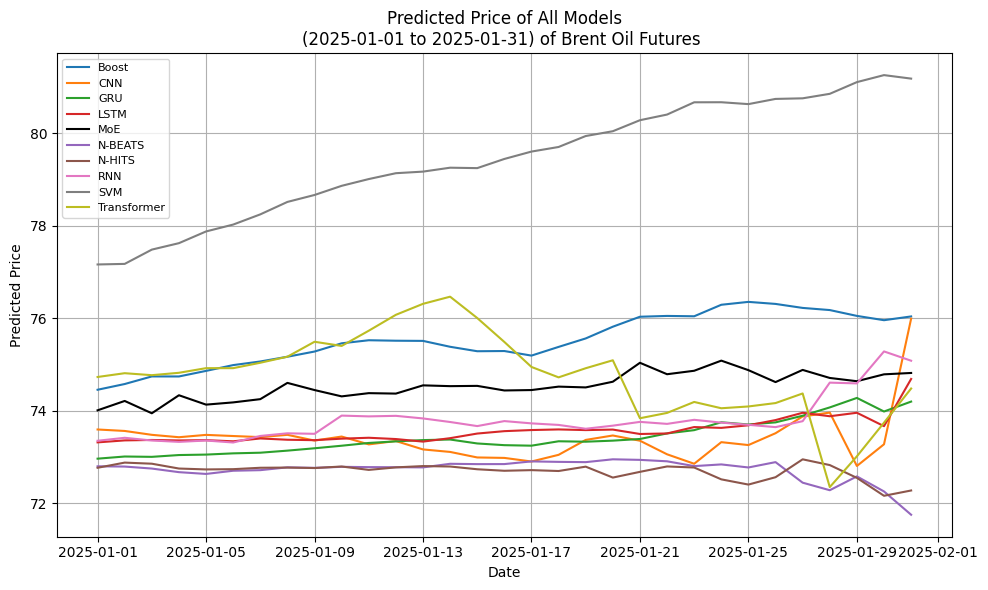

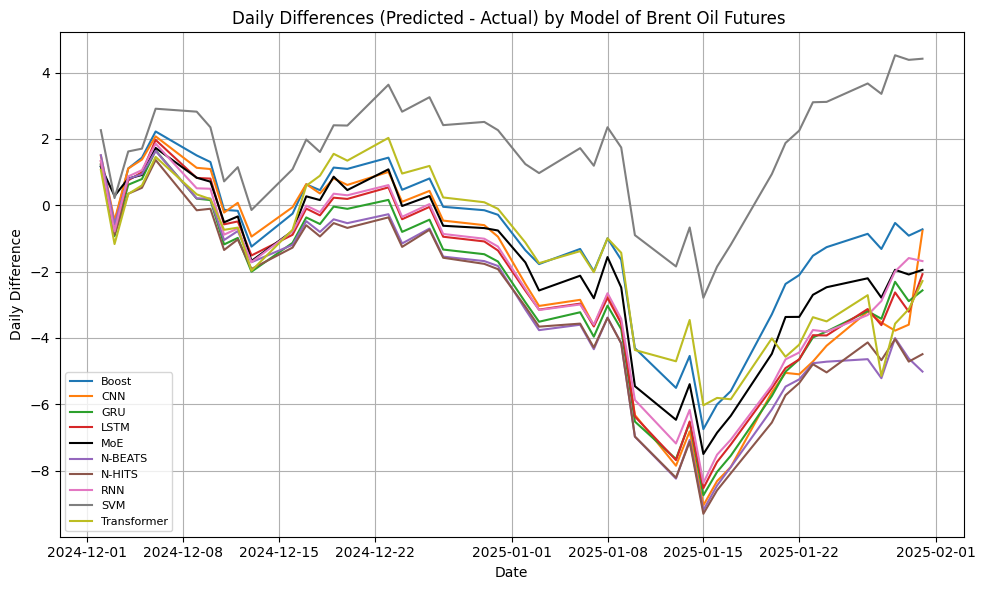


=== Model Scores (Incl. MoE) for Jan 2025 ===
         Model  cumulative_error  trend_matching_rate  normalized_error_score  \
0        Boost         56.675383             0.476190                0.905890   
1          SVM         50.094256             0.380952                1.000000   
2          RNN         94.046101             0.571429                0.371492   
3          MoE         78.605187             0.428571                0.592296   
4  Transformer         75.392044             0.380952                0.638243   
5          CNN        103.985978             0.523810                0.229352   
6         LSTM        100.282406             0.380952                0.282313   
7       N-HITS        119.896755             0.476190                0.001829   
8          GRU        102.994496             0.333333                0.243530   
9      N-BEATS        120.024675             0.380952                0.000000   

   combined_confidence  
0             0.605100  
1          

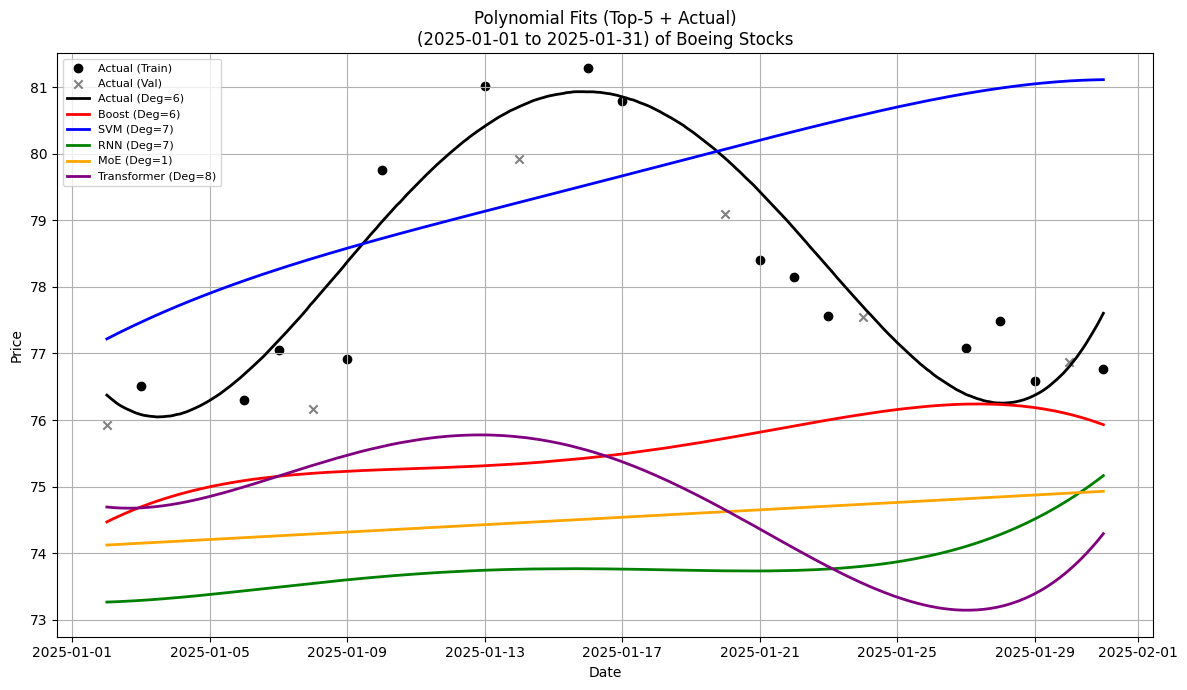

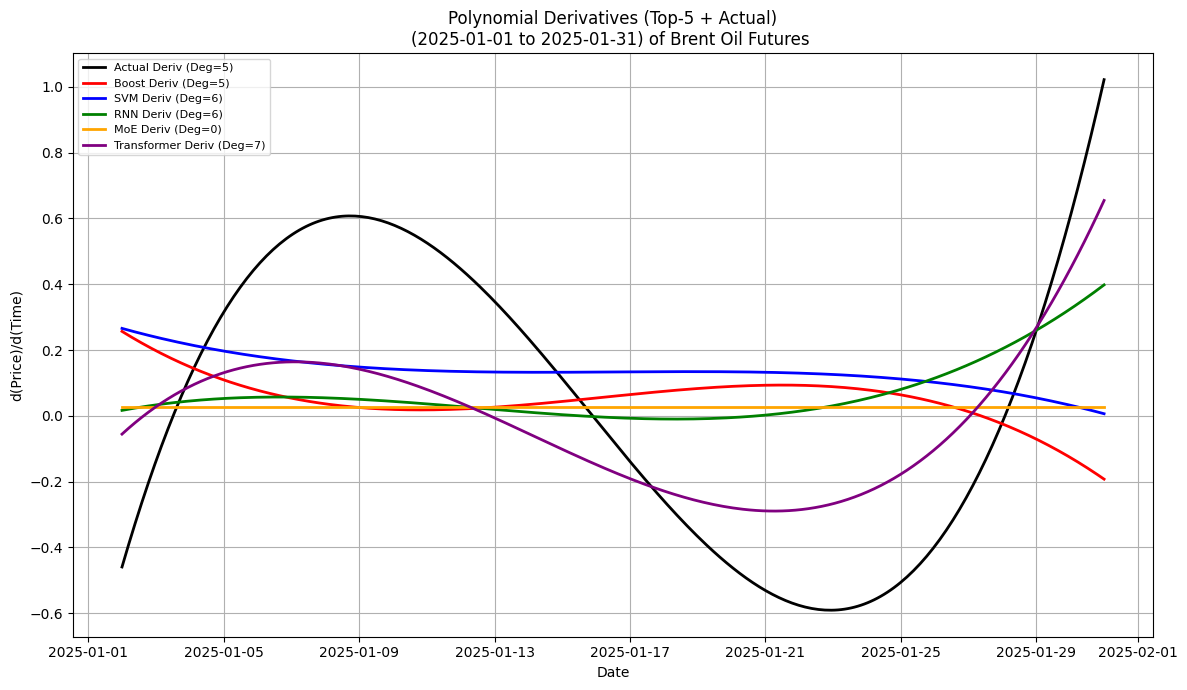

===== Brent Oil Futures  Trade Log =====
Flat(ignored) | 2025-01-02 -> 2025-01-02 (1 days) | Entry=75.93, Exit=75.93 (AbsDiff=0.00) | Return: 0.00% | EndCapital=100.00
Long  | 2025-01-03 -> 2025-01-13 (7 days) | Entry=76.51, Exit=81.01 (AbsDiff=4.50) | Return: 5.88% | EndCapital=105.88
Flat(ignored) | 2025-01-14 -> 2025-01-14 (1 days) | Entry=79.92, Exit=79.92 (AbsDiff=0.00) | Return: 0.00% | EndCapital=105.88
Flat(ignored) | 2025-01-15 -> 2025-01-15 (1 days) | Entry=82.03, Exit=82.03 (AbsDiff=0.00) | Return: 0.00% | EndCapital=105.88
Flat  | 2025-01-16 -> 2025-01-27 (8 days) | Entry=81.29, Exit=77.08 (AbsDiff=4.21) | Return: 0.00% | EndCapital=105.88
Flat(ignored) | 2025-01-28 -> 2025-01-28 (1 days) | Entry=77.49, Exit=77.49 (AbsDiff=0.00) | Return: 0.00% | EndCapital=105.88
Flat(ignored) | 2025-01-29 -> 2025-01-29 (1 days) | Entry=76.58, Exit=76.58 (AbsDiff=0.00) | Return: 0.00% | EndCapital=105.88
Flat(ignored) | 2025-01-30 -> 2025-01-30 (1 days) | Entry=76.87, Exit=76.87 (AbsDiff=0

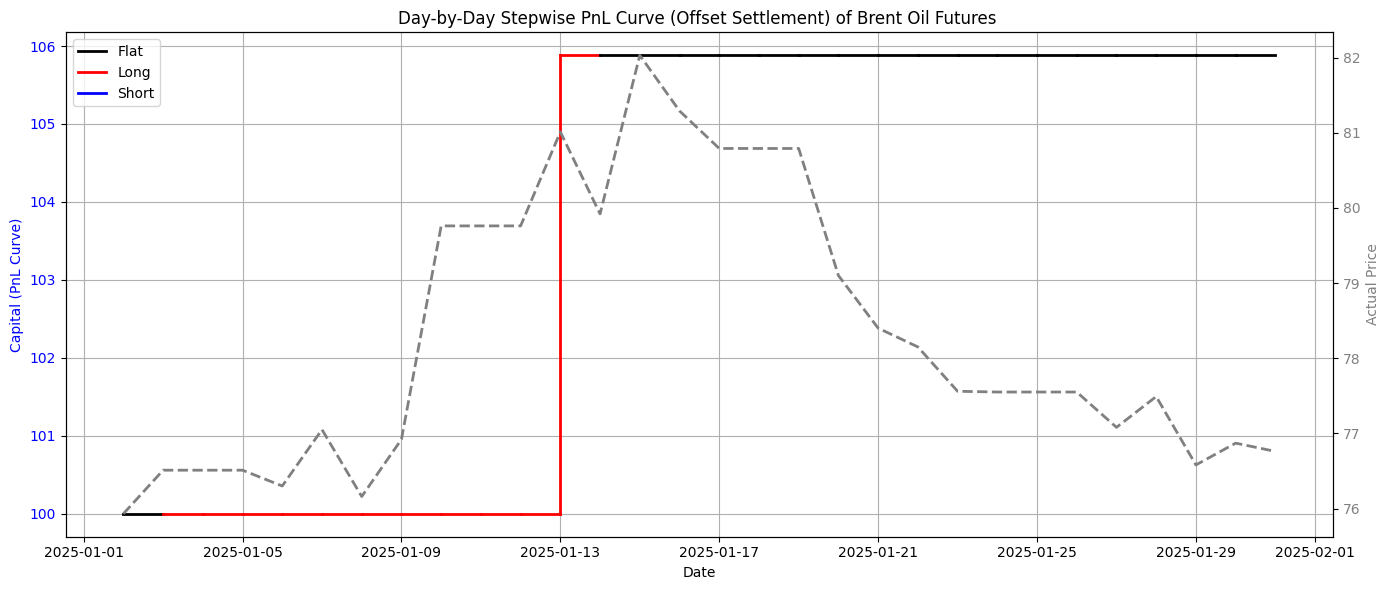

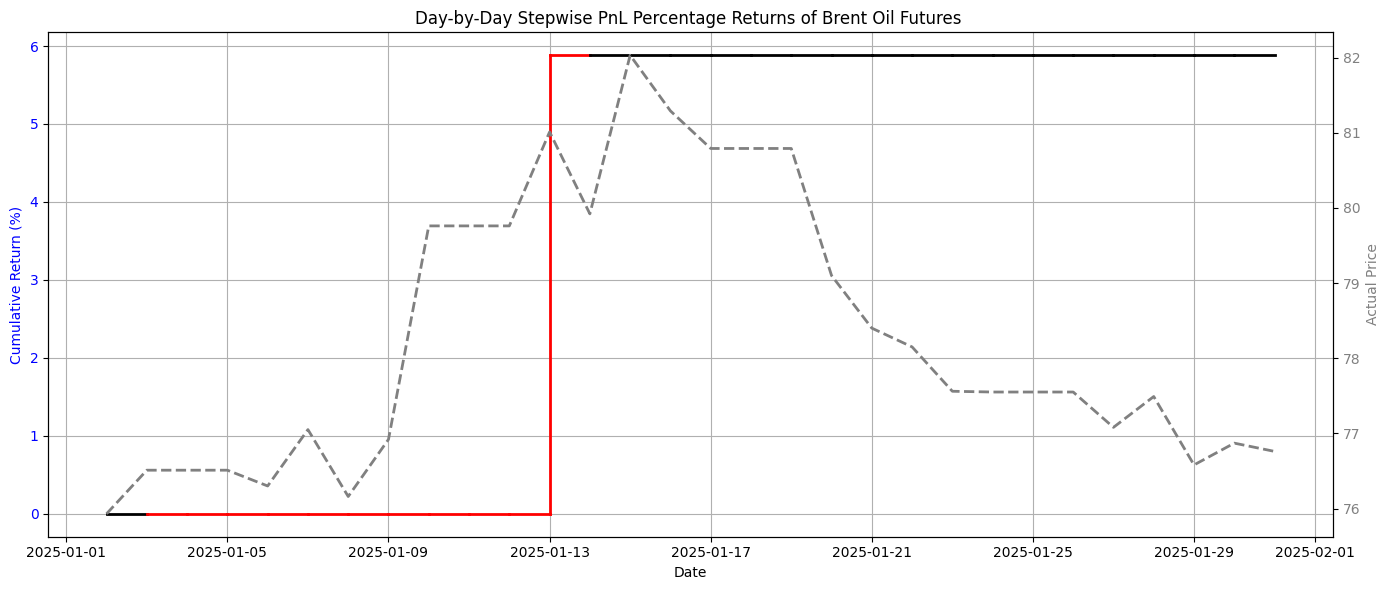

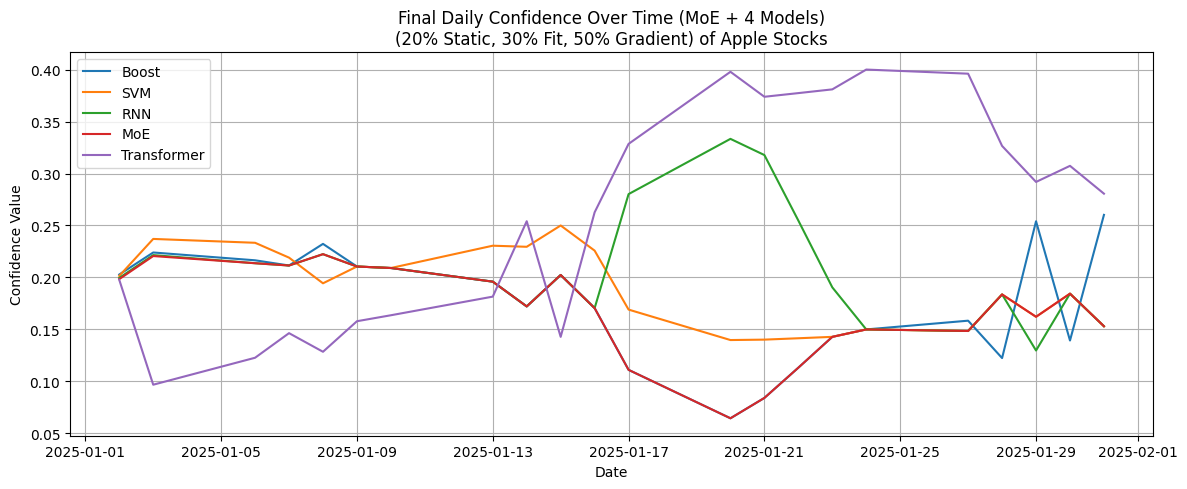

In [1]:
###############################################################################
# 0) Imports & Global Setup
###############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib

from numpy.polynomial.polynomial import polyfit, polyval
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

from matplotlib.lines import Line2D

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Global columns and constants
features = ["Price","Open","High","Low"]
WINDOW_SIZE = 35

# Date ranges
train_cutoff = pd.to_datetime("2024-07-01")
val_cutoff   = pd.to_datetime("2024-11-30")
test_cutoff  = pd.to_datetime("2024-12-01")

# For final evaluation & plotting (focus: Jan 2025)
PLOT_START = pd.to_datetime("2025-01-01")
PLOT_END   = pd.to_datetime("2025-01-31")

BEST_MODELS_DIR = "."

###############################################################################
# 1) Data Loading & Scaling
###############################################################################
def load_and_scale_data(train_csv="Brent Oil Futures Historical Data.csv",
                        complete_csv="Brent Oil Futures Historical Data_Complete.csv"):
    df_traincsv = pd.read_csv(train_csv)
    df_traincsv["Date"] = pd.to_datetime(df_traincsv["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_traincsv.columns:
            df_traincsv.drop(columns=[col], errors="ignore", inplace=True)

    # Clean columns
    for feat in features:
        if feat not in df_traincsv.columns:
            df_traincsv[feat] = np.nan
        else:
            df_traincsv[feat] = df_traincsv[feat].astype(str).str.replace(",", "", regex=True)
            df_traincsv[feat] = pd.to_numeric(df_traincsv[feat], errors="coerce")

    df_traincsv.sort_values("Date", inplace=True)
    df_traincsv.reset_index(drop=True, inplace=True)

    # Split into train/val/test
    df_trn = df_traincsv[df_traincsv["Date"] < train_cutoff].copy()
    df_val = df_traincsv[(df_traincsv["Date"] >= train_cutoff) & (df_traincsv["Date"] <= val_cutoff)].copy()
    df_tst = df_traincsv[df_traincsv["Date"] >= test_cutoff].copy()

    # Scale only on training subset
    df_trn_nonan = df_trn.dropna(subset=features)
    scaler = MinMaxScaler()
    if not df_trn_nonan.empty:
        scaler.fit(df_trn_nonan[features])

    def apply_scaler(df_sub):
        sub_nonan = df_sub.dropna(subset=features)
        if sub_nonan.empty:
            return df_sub
        df_sub.loc[sub_nonan.index, features] = scaler.transform(sub_nonan[features])
        return df_sub

    df_trn_scaled = apply_scaler(df_trn)
    df_val_scaled = apply_scaler(df_val)
    # For test, fill missing with min of training, then scale
    df_tst_scaled = df_tst.copy()
    if not df_tst_scaled.empty and not df_trn_nonan.empty:
        train_mins = df_trn_nonan[features].min()
        df_tst_filled = df_tst_scaled[features].fillna(train_mins)
        df_tst_scaled.loc[:, features] = scaler.transform(df_tst_filled)

    df_scaled = pd.concat([df_trn_scaled, df_val_scaled, df_tst_scaled], ignore_index=True)
    df_scaled.sort_values("Date", inplace=True)
    df_scaled.reset_index(drop=True, inplace=True)

    # Also load the more complete CSV for raw unscaled data
    df_complete = pd.read_csv(complete_csv)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_complete.columns:
            df_complete.drop(columns=[col], errors="ignore", inplace=True)
    for feat in features:
        df_complete[feat] = df_complete[feat].astype(str).str.replace(",", "", regex=True).astype(float)
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler

###############################################################################
# 2) PyTorch Model Definitions
###############################################################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64,128,3)
            with torch.no_grad():
                dummy = torch.zeros(1,4,window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1]*outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size,4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4,128,num_layers=2,batch_first=True,dropout=0.1)
            self.fc = nn.Linear(128,4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(4,128,num_layers=2,batch_first=True,dropout=0.1)
            self.fc = nn.Linear(128,4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(4,128,num_layers=2,nonlinearity="relu",batch_first=True,dropout=0.1)
            self.fc = nn.Linear(128,4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4,128,num_layers=3,batch_first=True,dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128,4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4,128)
            enc_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=3)
            self.fc = nn.Linear(128,4)
        elif model_type in ["N-BEATS","N-HITS"]:
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type=="CNN":
            x= x.permute(0,2,1)
            x= F.relu(self.conv1(x))
            x= F.relu(self.conv2(x))
            x= x.view(x.size(0),-1)
            return self.fc(x)

        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _= self.rnn(x)
            out= out[:,-1,:]
            return self.fc(out)

        elif self.model_type=="EnhancedLSTM":
            out, _= self.rnn(x)
            out= out[:,-1,:]
            out= self.bn(out)
            out= self.dropout(out)
            return self.fc(out)

        elif self.model_type=="Transformer":
            x= self.input_linear(x)
            x= x.permute(1,0,2)
            x= self.transformer_encoder(x)
            x= x[-1,:,:]
            return self.fc(x)

        elif self.model_type in ["N-BEATS","N-HITS"]:
            xflat= x.reshape(x.size(0), -1)
            forecast= 0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast
        else:
            raise ValueError("Invalid model_type")

class SklearnWrapper:
    """
    Simple wrapper so we can call sklearn regressors similarly to a PyTorch model.
    """
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        arr = x.cpu().numpy().reshape(1,-1)
        pred = self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def load_torch_model(model_type, window_size, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[PyTorch] Loading {model_type} from {path}")
    net = BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(path, map_location=device))
    net.eval()
    return net

def load_sklearn_model(model_type, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[sklearn] Loading {model_type} => {path}")
    loaded = joblib.load(path)
    return SklearnWrapper(loaded)

###############################################################################
# 3) Rolling Multi-Day Forecast with All Models (Including MoE)
###############################################################################
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    """
    Returns the scaled array of the last 'window' days of features
    prior to current_date.
    """
    mask= df_actual["Date"]< current_date
    sub= df_actual.loc[mask].copy()
    sub.sort_values("Date", inplace=True)
    if len(sub) < window:
        return None
    sub[features]= sub[features].fillna(method="ffill").fillna(method="bfill")
    arr= scaler.transform(sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.01):
    """
    Rolling forecast with mild random noise => more volatility.
    """
    def add_noise_4d(prices, std=0.01):
        noise= np.random.normal(0.0, std, size=prices.shape)
        return np.clip(prices + noise, a_min=0, a_max=None)

    arr_window= get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer= np.copy(arr_window)
    forecast_records=[]
    cur_dt= pd.to_datetime(start_date)

    for i in range(horizon):
        X_in= torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            out_scaled= model(X_in).cpu().numpy()[0]
        out_unscaled= scaler.inverse_transform(out_scaled.reshape(1,-1))[0]
        out_noisy= add_noise_4d(out_unscaled, noise_std)

        dayx= cur_dt + pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": out_noisy[0],
            "Pred_Open_unscaled":  out_noisy[1],
            "Pred_High_unscaled":  out_noisy[2],
            "Pred_Low_unscaled":   out_noisy[3]
        })

        out_noisy_scaled= scaler.transform(out_noisy.reshape(1,-1))[0]
        rolling_buffer= np.vstack([rolling_buffer[1:], out_noisy_scaled.reshape(1,-1)])

    return pd.DataFrame(forecast_records)

def rolling_train_validate_predict_moe(
    df_full, scaler_obj, model_types,
    start_train_cutoff=pd.to_datetime("2024-07-01"),
    start_val_cutoff=pd.to_datetime("2024-11-30"),
    start_pred=pd.to_datetime("2024-12-01"),
    end_pred=pd.to_datetime("2025-01-01"),
    horizon_days=30
):
    """
    For each day in [start_pred..end_pred], load the best_{model_type}_{YYYY-mm-dd}_V1,
    forecast next horizon_days, combine results.
    If "MoE" is in model_types, try to load a corresponding file. If none found, skip.
    """
    df_sorted= df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    date_rng= pd.date_range(start_pred, end_pred, freq="D")
    all_records=[]

    for i, day_i in enumerate(date_rng):
        train_cutoff_i= start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i  = start_val_cutoff   + pd.Timedelta(days=i)
        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  train_cutoff={train_cutoff_i.date()}  val_cutoff={val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()}")

        model_dict={}
        for mt in model_types:
            # Special case for "MoE"
            if mt=="MoE":
                out_file= f"best_MoE_{day_i.strftime('%Y-%m-%d')}_V1"
                pt_file= os.path.join(BEST_MODELS_DIR, out_file+".pt")
                pkl_file= os.path.join(BEST_MODELS_DIR, out_file+".pkl")
                if os.path.exists(pt_file):
                    net= load_torch_model(mt, WINDOW_SIZE, pt_file)
                    model_dict[mt]= net
                elif os.path.exists(pkl_file):
                    net= load_sklearn_model(mt, pkl_file)
                    model_dict[mt]= net
                else:
                    print(f"[MoE] No saved file for {day_i.date()}, skipping load.")
                continue

            # Normal model
            out_file= f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file+= ".pkl"
                fullpath= os.path.join(BEST_MODELS_DIR, out_file)
                if os.path.exists(fullpath):
                    net= load_sklearn_model(mt, fullpath)
                    model_dict[mt]= net
            else:
                out_file+= ".pt"
                fullpath= os.path.join(BEST_MODELS_DIR, out_file)
                if os.path.exists(fullpath):
                    net= load_torch_model(mt, WINDOW_SIZE, fullpath)
                    model_dict[mt]= net

        # Forecast
        for mt, netobj in model_dict.items():
            df_fc= forecast_n_days_from_date(
                model=netobj,
                df_actual=df_sorted,
                start_date=day_i,
                window=WINDOW_SIZE,
                horizon=horizon_days,
                device=device,
                scaler=scaler_obj,
                noise_std=0.01
            )
            if not df_fc.empty:
                df_fc["BaseDate"] = day_i
                df_fc["Model"]    = mt
                all_records.append(df_fc)

    df_all= pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    if not df_all.empty:
        df_all.sort_values(["Model","BaseDate","ForecastDate"], inplace=True)
    return df_all

###############################################################################
# 4) Compute “Super Advanced” MoE if no MoE loaded
###############################################################################
def build_mini_models_table(final_rolling_fcst, df_actual):
    """
    Use [2024-12-01..2025-01-01] as the weighting period to measure model performance
    for weighting the MoE if we need to build it ourselves.
    """
    start_jan= pd.to_datetime("2024-12-01")
    end_jan=   pd.to_datetime("2025-01-01")

    df_jan= final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"]>= start_jan)&
        (final_rolling_fcst["ForecastDate"]<= end_jan)
    ].copy()
    if df_jan.empty:
        return pd.DataFrame(), 0.01

    df_act_jan= df_actual[
        (df_actual["Date"]>= start_jan)&
        (df_actual["Date"]<= end_jan)
    ].copy()
    df_act_jan.rename(columns={"Date":"ForecastDate","Price":"ActualPrice"}, inplace=True)

    df_merge= pd.merge(
        df_jan[["Model","BaseDate","ForecastDate","Pred_Price_unscaled"]],
        df_act_jan[["ForecastDate","ActualPrice"]],
        on="ForecastDate", how="inner"
    )
    df_merge["AbsError"] = (df_merge["Pred_Price_unscaled"] - df_merge["ActualPrice"]).abs()

    # mae
    g_mae= df_merge.groupby(["Model","BaseDate"])["AbsError"].mean().reset_index()
    g_mae.rename(columns={"AbsError":"mae_jan"}, inplace=True)

    # slope alignment => quick polynomial fit
    def poly_slope_diff(sub):
        sub= sub.sort_values("ForecastDate")
        xvals= np.arange(len(sub))
        yvals= sub["Pred_Price_unscaled"].values
        if len(yvals)< 4:
            return 0.5
        coefs= polyfit(xvals,yvals,deg=2)
        y_pred= polyval(xvals, coefs)
        resid= yvals- y_pred
        sse= np.mean(resid**2)
        return float(np.exp(-sse))

    def group_slope_func(grp):
        grp["slopeAlign_jan"]= poly_slope_diff(grp)
        return grp

    df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
    df_slope_agg= df_slope.groupby(["Model","BaseDate"])["slopeAlign_jan"].mean().reset_index()

    # real vol
    df_act_jan_sorted= df_act_jan.drop_duplicates("ForecastDate").copy()
    df_act_jan_sorted.sort_values("ForecastDate", inplace=True)
    df_act_jan_sorted["DayChange"]= df_act_jan_sorted["ActualPrice"].diff()
    real_vol= df_act_jan_sorted["DayChange"].std(skipna=True)
    if pd.isna(real_vol) or real_vol< 1e-9:
        real_vol= 0.01

    def mini_volatility(sub):
        sub= sub.sort_values("ForecastDate")
        sub["DayChange"]= sub["Pred_Price_unscaled"].diff()
        vol_= sub["DayChange"].std(skipna=True)
        if pd.isna(vol_):
            vol_= 0.01
        return vol_

    g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()
    g_vol.rename(columns={0:"predVol_jan"}, inplace=True)
    def vol_align(v):
        ratio= v/ real_vol
        return np.exp(-abs(ratio-1.0))
    g_vol["volAlign_jan"]= g_vol["predVol_jan"].apply(vol_align)

    mini_models= pd.merge(g_mae, df_slope_agg, on=["Model","BaseDate"], how="left")
    mini_models= pd.merge(mini_models, g_vol[["Model","BaseDate","predVol_jan","volAlign_jan"]],
                          on=["Model","BaseDate"], how="left")

    mae_min= mini_models["mae_jan"].min()
    mae_max= mini_models["mae_jan"].max()
    if np.isclose(mae_min, mae_max):
        mini_models["baseAcc"]= 1.0
    else:
        mini_models["baseAcc"]= 1.0 - ((mini_models["mae_jan"]- mae_min)/(mae_max- mae_min))

    return mini_models, real_vol

def compute_super_advanced_moe(final_rolling_fcst, df_actual):
    """
    Weighted "Mixture of Experts" for entire [2024-12-01..2025-01-31].
    If no MoE model is loaded from disk, we create one by weighting predictions
    from other models found in final_rolling_fcst.
    """
    print("\n=== SUPER ADVANCED MOE w/ Polynomials & Voting ===\n")
    mini_models, real_vol= build_mini_models_table(final_rolling_fcst, df_actual)
    if mini_models.empty:
        print("No january data => fallback => uniform daily average")
        return pd.DataFrame(columns=["ForecastDate","MOE_Price"])

    mm_dict={}
    for i, row in mini_models.iterrows():
        mm_dict[(row["Model"], row["BaseDate"])] = {
            "baseAcc": row["baseAcc"],
            "slopeAlign_jan": row["slopeAlign_jan"],
            "volAlign_jan": row["volAlign_jan"]
        }

    start_moe= pd.to_datetime("2024-12-01")
    end_moe=   pd.to_datetime("2025-01-31")
    all_days=  pd.date_range(start_moe, end_moe, freq="D")

    records=[]
    for d in all_days:
        df_d= final_rolling_fcst[ final_rolling_fcst["ForecastDate"]== d ].copy()
        if df_d.empty:
            continue

        d_prev= d - pd.Timedelta(days=1)
        ups= 0
        downs= 0
        total= 0
        w_sums= 0.0
        weighted_price= 0.0

        for idx, row in df_d.iterrows():
            m= row["Model"]
            bD= row["BaseDate"]
            if (m,bD) not in mm_dict:
                continue

            baseAcc= mm_dict[(m,bD)]["baseAcc"]
            slopeA= mm_dict[(m,bD)]["slopeAlign_jan"]
            volA=   mm_dict[(m,bD)]["volAlign_jan"]

            df_dprev= final_rolling_fcst[
                (final_rolling_fcst["Model"]==m)&
                (final_rolling_fcst["BaseDate"]==bD)&
                (final_rolling_fcst["ForecastDate"]==d_prev)
            ]
            if df_dprev.empty:
                dirFactor=1.0
            else:
                pd_today= row["Pred_Price_unscaled"]
                pd_yest=  df_dprev["Pred_Price_unscaled"].values[0]
                if pd_today> pd_yest:
                    ups += 1
                    dirFactor=1.1
                elif pd_today< pd_yest:
                    downs += 1
                    dirFactor=0.9
                else:
                    dirFactor=1.0
                total += 1

            w= baseAcc*slopeA*volA* dirFactor
            w_sums+= w
            weighted_price+= w* row["Pred_Price_unscaled"]

        if np.isclose(w_sums,0.0):
            day_moe= df_d["Pred_Price_unscaled"].mean()
        else:
            day_moe= weighted_price/ w_sums

        # If majority are up or down, nudge the final price
        if total>0:
            fraction_up= ups/ total
            fraction_down= downs/ total
            if fraction_up> 0.7:
                day_moe*= 1.01
            elif fraction_down> 0.7:
                day_moe*= 0.99

        # final mild noise
        day_moe+= np.random.normal(0, day_moe*0.002)
        records.append({"ForecastDate": d, "MOE_Price": day_moe})

    df_moe= pd.DataFrame(records)
    df_moe.sort_values("ForecastDate", inplace=True)
    return df_moe

def reduce_duplicates(df_in):
    agg_df = df_in.groupby(["Model","ForecastDate"], as_index=False).agg({
        "Pred_Price_unscaled":"mean"
    })
    return agg_df

def combine_base_and_moe(final_rolling_fc, df_moe):
    df_moe_cpy = df_moe.copy()
    df_moe_cpy["Model"] = "MoE"
    df_moe_cpy["BaseDate"] = pd.NaT
    df_moe_cpy.rename(columns={"MOE_Price":"Pred_Price_unscaled"}, inplace=True)

    df_base = final_rolling_fc[["Model","ForecastDate","Pred_Price_unscaled"]].copy()
    df_combined = pd.concat([df_base, df_moe_cpy], ignore_index=True)

    df_no_dupes = reduce_duplicates(df_combined)
    df_no_dupes.sort_values(["Model","ForecastDate"], inplace=True, ignore_index=True)
    return df_no_dupes

###############################################################################
# 5) Merge with Actual => Daily Differences
###############################################################################
def merge_with_actual_and_diff(df_all_models, df_actual):
    df_actual_cpy = df_actual[["Date","Price"]].rename(columns={"Price":"ActualPrice"}).copy()

    df_merged = pd.merge(
        df_all_models,
        df_actual_cpy,
        left_on="ForecastDate",
        right_on="Date",
        how="left"
    )
    df_merged.dropna(subset=["ActualPrice"], inplace=True)
    df_merged.drop(columns=["Date"], inplace=True, errors="ignore")

    df_merged.rename(columns={"ForecastDate":"Date"}, inplace=True)
    df_merged["DailyDiff"] = df_merged["Pred_Price_unscaled"] - df_merged["ActualPrice"]
    df_merged["AbsError"]  = df_merged["DailyDiff"].abs()

    df_merged.sort_values(["Model","Date"], inplace=True)
    df_merged.reset_index(drop=True, inplace=True)
    return df_merged

###############################################################################
# 6) Evaluate Errors & Confidence => produce df_scores
###############################################################################
def evaluate_models_confidence(df_diff):
    df_eval = df_diff[
        (df_diff["Date"]>= PLOT_START)&
        (df_diff["Date"]<= PLOT_END)
    ].copy()
    model_scores = {}
    for m in df_eval["Model"].unique():
        dsub= df_eval[df_eval["Model"]==m].copy()
        if dsub.empty:
            continue
        cum_err= dsub["AbsError"].sum()

        dsub.sort_values("Date", inplace=True)
        dsub["ActualDiff"] = dsub["ActualPrice"].diff()
        dsub["PredDiff"]   = dsub["Pred_Price_unscaled"].diff()
        dsub_valid= dsub.dropna(subset=["ActualDiff","PredDiff"]).copy()

        def sign_match(a,b):
            if a==0 and b==0:
                return True
            return np.sign(a)== np.sign(b)
        dsub_valid["TrendMatch"] = dsub_valid.apply(
            lambda r: 1 if sign_match(r["ActualDiff"], r["PredDiff"]) else 0,
            axis=1
        )
        trend_rate= dsub_valid["TrendMatch"].mean() if len(dsub_valid)>0 else 0.0

        model_scores[m] = {
            "cumulative_error": cum_err,
            "trend_matching_rate": trend_rate
        }

    df_scores= pd.DataFrame.from_dict(model_scores, orient="index").reset_index()
    df_scores.rename(columns={"index":"Model"}, inplace=True)

    if not df_scores.empty:
        ce_min= df_scores["cumulative_error"].min()
        ce_max= df_scores["cumulative_error"].max()
        if not np.isclose(ce_min, ce_max):
            df_scores["normalized_error_score"] = 1.0 - (df_scores["cumulative_error"]-ce_min)/(ce_max-ce_min)
        else:
            df_scores["normalized_error_score"] = 1.0

        # Weighted combo => 70% trend, 30% error
        df_scores["combined_confidence"] = 0.7*df_scores["trend_matching_rate"] + 0.3*df_scores["normalized_error_score"]
        df_scores.sort_values("combined_confidence", ascending=False, inplace=True)
        df_scores.reset_index(drop=True, inplace=True)

    return df_scores

def select_top5_including_moe(df_scores):
    """
    Always include the 'MoE' model in top-5, plus 4 others with highest confidence.
    Then re-normalize their 'combined_confidence' so sum=1.
    """
    if df_scores.empty:
        return df_scores.copy()

    if "MoE" not in df_scores["Model"].values:
        # If MoE not present at all, just pick top-5
        top5 = df_scores.head(5).copy()
        csum = top5["combined_confidence"].sum()
        if csum>0:
            top5["combined_confidence"] /= csum
        return top5

    # Otherwise, separate out MoE row
    df_sorted = df_scores.sort_values("combined_confidence", ascending=False).reset_index(drop=True)
    moe_row = df_sorted[df_sorted["Model"]=="MoE"].iloc[0]
    df_no_moe = df_sorted[df_sorted["Model"]!="MoE"].copy()

    # pick top 4 from the others
    top4 = df_no_moe.head(4).copy()
    top5 = pd.concat([top4, pd.DataFrame([moe_row])], ignore_index=True)
    top5.sort_values("combined_confidence", ascending=False, inplace=True, ignore_index=True)

    # re-normalize
    csum = top5["combined_confidence"].sum()
    if csum> 0:
        top5["combined_confidence"] /= csum

    return top5

###############################################################################
# 7) Polynomial Fit for the forced top-5 + Actual in [2025-01-01..2025-01-31]
###############################################################################
def polynomial_fit_top5_models(df_diff, df_top5, max_degree=70):
    """
    Returns a dictionary of best polynomials => {model: {degree, mse, coeffs}}
    plus a merged DataFrame with [Date, Actual, top5-model columns, mdates_num].
    """
    top5_models = df_top5["Model"].tolist()

    # Filter the underlying df_diff to Jan 2025 range
    df_test = df_diff[
        (df_diff["Date"]>= PLOT_START)&
        (df_diff["Date"]<= PLOT_END)
    ].copy()
    if df_test.empty:
        print("No data in test range for polynomial fitting.")
        return {}, pd.DataFrame()

    # Pivot => each model's predicted price in separate column
    df_pivot = df_test.pivot_table(
        index="Date", columns="Model", values="Pred_Price_unscaled", aggfunc="mean"
    ).reset_index()

    # Also keep actual
    df_actual_only = df_test.drop_duplicates("Date")[["Date","ActualPrice"]].copy()
    df_merged = pd.merge(df_pivot, df_actual_only, on="Date", how="inner")
    df_merged.rename(columns={"ActualPrice":"Actual"}, inplace=True)
    df_merged.sort_values("Date", inplace=True)
    df_merged.reset_index(drop=True, inplace=True)

    # We want columns: "Actual" + top5
    columns_to_fit = ["Actual"] + top5_models
    df_merged = df_merged[["Date"] + columns_to_fit].dropna()

    if df_merged.empty:
        print("No overlapping data for polynomial fit.")
        return {}, pd.DataFrame()

    df_merged["mdates_num"] = mdates.date2num(df_merged["Date"])
    n_points = len(df_merged)
    idx = np.arange(n_points)
    # simple train/val split: 3/4 train, 1/4 val
    val_mask = (idx % 4 == 0)
    train_mask = ~val_mask

    best_poly = {}

    from sklearn.metrics import mean_squared_error
    for col in columns_to_fit:
        x_train= df_merged.loc[train_mask,"mdates_num"].values
        y_train= df_merged.loc[train_mask,col].values
        x_val= df_merged.loc[val_mask,"mdates_num"].values
        y_val= df_merged.loc[val_mask,col].values

        best_deg = None
        best_mse = float("inf")
        best_coefs= None
        for d_ in range(1, max_degree+1):
            if len(x_train)<= d_:
                break
            coefs = np.polyfit(x_train, y_train, d_)
            y_pred_val= np.polyval(coefs, x_val)
            mse_ = mean_squared_error(y_val, y_pred_val)
            if mse_ < best_mse:
                best_mse= mse_
                best_deg= d_
                best_coefs= coefs

        if best_coefs is None:
            best_poly[col] = {
                "degree": 0,
                "mse": 9999.0,
                "coeffs": [0.0]
            }
        else:
            best_poly[col] = {
                "degree": best_deg,
                "mse": best_mse,
                "coeffs": best_coefs
            }

    return best_poly, df_merged

def format_poly(coefs):
    terms=[]
    deg= len(coefs)-1
    for i,c in enumerate(coefs):
        p= deg-i
        sign_part= f"{c:+.4e}"
        if p>1:
            terms.append(f"{sign_part}*x^{p}")
        elif p==1:
            terms.append(f"{sign_part}*x")
        else:
            terms.append(f"{sign_part}")
    expr= "".join(terms).replace("+-","-")
    if expr.startswith("+"):
        expr= expr[1:]
    return expr

def plot_polynomial_fits(df_merged, best_poly, top5_models):
    columns_to_fit = ["Actual"] + top5_models
    if df_merged.empty or not best_poly:
        print("No data to plot for polynomial fits.")
        return

    # Print results
    print("\n=== Best Polynomial Fitting (Forced Top-5 + Actual) ===")
    for col in columns_to_fit:
        info = best_poly[col]
        expr = format_poly(info["coeffs"])
        print(f"[{col}] => Deg={info['degree']}  ValMSE={info['mse']:.6f}")
        print(f"    y = {expr}\n")

    # Plot polynomials
    plt.figure(figsize=(12,7))
    color_list= ["black","red","blue","green","orange","purple","pink","brown","olive","cyan"]
    color_map= {}
    color_map["Actual"] = "black"
    for i,m in enumerate(top5_models):
        if i < len(color_list)-1:
            color_map[m] = color_list[i+1]
        else:
            color_map[m] = "gray"

    # Distinguish train vs. val
    n_points = len(df_merged)
    idx= np.arange(n_points)
    val_mask = (idx % 4 == 0)
    train_mask = ~val_mask

    plt.scatter(df_merged.loc[train_mask,"Date"], df_merged.loc[train_mask,"Actual"],
                color="black", marker="o", label="Actual (Train)")
    plt.scatter(df_merged.loc[val_mask,"Date"], df_merged.loc[val_mask,"Actual"],
                color="gray", marker="x", label="Actual (Val)")

    x_dense = np.linspace(df_merged["mdates_num"].min(), df_merged["mdates_num"].max(), 300)
    x_dense_dates= [mdates.num2date(xx) for xx in x_dense]

    for col in columns_to_fit:
        coefs= best_poly[col]["coeffs"]
        y_dense= np.polyval(coefs, x_dense)
        c= color_map.get(col,"gray")
        plt.plot(x_dense_dates, y_dense, color=c, lw=2, label=f"{col} (Deg={best_poly[col]['degree']})")

    plt.title("Polynomial Fits (Top-5 + Actual)\n(2025-01-01 to 2025-01-31) of Boeing Stocks")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(prop={'size':8})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Derivatives
    plt.figure(figsize=(12,7))
    for col in columns_to_fit:
        coefs= best_poly[col]["coeffs"]
        d_coefs= np.polyder(coefs)
        y_deriv= np.polyval(d_coefs, x_dense)
        c= color_map.get(col,"gray")
        plt.plot(x_dense_dates, y_deriv, color=c, lw=2,
                 label=f"{col} Deriv (Deg={best_poly[col]['degree']-1})")

    plt.title("Polynomial Derivatives (Top-5 + Actual)\n(2025-01-01 to 2025-01-31) of Brent Oil Futures ")
    plt.xlabel("Date")
    plt.ylabel("d(Price)/d(Time)")
    plt.legend(prop={'size':8})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
# 8) HELPER PLOTS for All Models and Differences
###############################################################################
def plot_predicted_price_all_models(df_rolled, from_d, to_d):
    """
    Plots the predicted price vs. date for each model in [from_d..to_d].
    """
    df_plot = df_rolled[
        (df_rolled["ForecastDate"] >= from_d) & 
        (df_rolled["ForecastDate"] <= to_d)
    ].copy()
    if df_plot.empty:
        print("No data to plot in the specified date range.")
        return
    
    # Pivot so each model's mean predicted price is in its own column
    pivot_df = df_plot.pivot_table(
        index="ForecastDate", 
        columns="Model", 
        values="Pred_Price_unscaled", 
        aggfunc="mean"
    )
    pivot_df.sort_index(inplace=True)
    
    plt.figure(figsize=(10,6))

    for model_name in pivot_df.columns:
        color = "black" if model_name == "MoE" else None
        plt.plot(
            pivot_df.index, 
            pivot_df[model_name], 
            label=model_name,
            color=color
        )
    plt.title(f"Predicted Price of All Models\n({from_d.date()} to {to_d.date()}) of Brent Oil Futures ")
    plt.xlabel("Date")
    plt.ylabel("Predicted Price")
    plt.legend(prop={'size':8})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_daily_differences_all_models(df_diff):
    """
    Plots the daily difference (Predicted - Actual) vs. date for each model.
    This uses the 'df_diff' DataFrame, which has columns:
      - 'Model'
      - 'Date'
      - 'DailyDiff'
    """
    if df_diff.empty:
        print("No data in df_diff to plot daily differences.")
        return

    df_plot = df_diff.copy()
    df_plot.sort_values(["Model","Date"], inplace=True)

    plt.figure(figsize=(10,6))
    
    for model_name in df_plot["Model"].unique():
        sub = df_plot[df_plot["Model"]==model_name]
        color = "black" if model_name == "MoE" else None
        plt.plot(
            sub["Date"], 
            sub["DailyDiff"], 
            label=model_name,
            color=color
        )

    plt.title("Daily Differences (Predicted - Actual) by Model of Brent Oil Futures ")
    plt.xlabel("Date")
    plt.ylabel("Daily Difference")
    plt.legend(prop={'size':8})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
####################   Actual Implementation of the Code   ####################
###############################################################################
if __name__ == "__main__":

    # A) Load & Scale
    df_scaled, df_complete_all, scaler = load_and_scale_data(
        "Brent Oil Futures Historical Data.csv",
        "Brent Oil Futures Historical Data_Complete.csv"
    )

    # B) Rolling Forecasts for [2024-12-01 .. 2025-01-02]
    all_model_types = [
        "LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost","MoE"
    ]
    final_rolling_fc= rolling_train_validate_predict_moe(
        df_full= df_complete_all,
        scaler_obj= scaler,
        model_types= all_model_types,
        start_train_cutoff= train_cutoff,
        start_val_cutoff=   val_cutoff,
        start_pred= pd.to_datetime("2024-12-01"),
        end_pred=   pd.to_datetime("2025-01-02"),
        horizon_days= 30
    )
    print("\n=== HEAD of final_rolling_fc ===")
    print(final_rolling_fc.head(10))

    # C) If MoE wasn't loaded, compute it via “Super Advanced” approach
    if not any(final_rolling_fc["Model"]=="MoE"):
        df_moe= compute_super_advanced_moe(final_rolling_fc, df_complete_all)
        df_rolled_all= combine_base_and_moe(final_rolling_fc, df_moe)
    else:
        df_rolled_all= final_rolling_fc.copy()

    # D) Quick Plot of All Models in Jan 2025
    plot_predicted_price_all_models(
        df_rolled_all,
        from_d= PLOT_START,
        to_d=   PLOT_END
    )

    # E) Merge w/ actual => daily differences
    df_diff_all= merge_with_actual_and_diff(df_rolled_all, df_complete_all)
    plot_daily_differences_all_models(df_diff_all)

    # F) Evaluate errors => df_scores => forcibly select top-5 (MoE included)
    df_scores= evaluate_models_confidence(df_diff_all)
    print("\n=== Model Scores (Incl. MoE) for Jan 2025 ===")
    print(df_scores)

    df_top5_incl_moe= select_top5_including_moe(df_scores)
    print("\n=== Forced Top-5 (MoE + 4) with Re-Normalized Confidence ===")
    print(df_top5_incl_moe)

    # Convert that combined_confidence into a simple static_conf dict
    # (We’ll treat these as the "static" portion for the dynamic weighting)
    static_conf = {}
    for i,row in df_top5_incl_moe.iterrows():
        static_conf[row["Model"]] = row["combined_confidence"]

    # G) Polynomial Fit for these top-5
    best_poly, df_test_poly = polynomial_fit_top5_models(df_diff_all, df_top5_incl_moe, max_degree=70)
    plot_polynomial_fits(df_test_poly, best_poly, df_top5_incl_moe["Model"].tolist())


###############################################################################
# 8) Confidence-Based Voting Trading Strategy (Adapted to MoE + 4 Others)
###############################################################################
def re_normalize(d):
    s = sum(d.values())
    if s > 1e-9:
        for k in d:
            d[k] /= s
    else:
        n = len(d)
        for k in d:
            d[k] = 1.0 / n

def confidence_based_voting_trading(df_test_poly, best_poly_info, best_model_names, static_conf):
    """
    Given:
      - df_test_poly: a DataFrame with columns ["Date","Actual","mdates_num"] for Jan 2025
      - best_poly_info: dict -> best_poly_info[model]["coeffs"]
      - best_model_names: list of the 5 models (MoE + 4 others)
      - static_conf: dictionary of base confidences for these 5 models

    Returns:
      df_sim: final DataFrame with signals, capital, etc.
      trade_log: list of trades
      final_conf_history: daily record of each model's composite confidence
    """
    df_test_poly = df_test_poly.sort_values("Date").reset_index(drop=True)
    n_days = len(df_test_poly)

    # 1) Compute each model's polynomial predicted prices
    model_pred_prices = {}
    for model in best_model_names:
        c = best_poly_info[model]["coeffs"]
        model_pred_prices[model] = np.polyval(c, df_test_poly["mdates_num"])

    # 2) Setup dynamic confidence
    dyn_fit_conf    = {m: 0.5 for m in best_model_names}
    dyn_grad_conf   = {m: 0.5 for m in best_model_names}
    dyn_static_conf = {m: static_conf[m] for m in best_model_names}

    # Weighted formula: (10% static, 30% fit, 60% gradient) => can be changed
    w_static = 0.2
    w_fit    = 0.3
    w_grad   = 0.5

    # Step sizes
    alpha_fit_up     = 0.2
    alpha_fit_down   = 0.2
    alpha_grad_up    = 0.3
    alpha_grad_down  = 0.4
    alpha_static_up  = 0.1
    alpha_static_down= 0.1

    fit_threshold    = 1.0
    static_threshold = 1.0

    consecutive_all_wrong = 0
    MAX_CONSECUTIVE_ALL_WRONG = 2
    threshold = 0.6

    signals = np.zeros(n_days, dtype=int)
    final_conf_history = pd.DataFrame(index=range(n_days), columns=best_model_names)

    def abs_err(m, i):
        return abs(model_pred_prices[m][i] - df_test_poly.loc[i, "Actual"])

    for i in range(n_days):
        if i > 0:
            # 1) Update dynamic fitting confidence
            for m in best_model_names:
                pred_change = model_pred_prices[m][i] - model_pred_prices[m][i - 1]
                actual_change = df_test_poly.loc[i, "Actual"] - df_test_poly.loc[i - 1, "Actual"]
                err = abs(pred_change - actual_change)
                if err < fit_threshold:
                    dyn_fit_conf[m] += alpha_fit_up
                else:
                    dyn_fit_conf[m] -= alpha_fit_down
                dyn_fit_conf[m] = max(0, min(1, dyn_fit_conf[m]))

            # 2) Update dynamic gradient confidence
            for m in best_model_names:
                model_sign = np.sign(model_pred_prices[m][i] - model_pred_prices[m][i - 1])
                actual_sign = np.sign(df_test_poly.loc[i, "Actual"] - df_test_poly.loc[i - 1, "Actual"])
                if model_sign == actual_sign:
                    dyn_grad_conf[m] += alpha_grad_up
                else:
                    dyn_grad_conf[m] -= alpha_grad_down
                dyn_grad_conf[m] = max(0, min(1, dyn_grad_conf[m]))

            # 3) Update dynamic static confidence
            for m in best_model_names:
                error_static = abs_err(m, i)
                if error_static < static_threshold:
                    dyn_static_conf[m] += alpha_static_up
                else:
                    dyn_static_conf[m] -= alpha_static_down
                dyn_static_conf[m] = max(0, min(1, dyn_static_conf[m]))

        # Merge components
        daily_conf = {}
        for m in best_model_names:
            daily_conf[m] = (w_static * dyn_static_conf[m] +
                             w_fit    * dyn_fit_conf[m] +
                             w_grad   * dyn_grad_conf[m])
        re_normalize(daily_conf)

        # Record daily composite confidence
        for m in best_model_names:
            final_conf_history.loc[i, m] = daily_conf[m]

        # Weighted vote
        if i==0:
            # No movement from i-1 to i if i=0
            signals[i] = 0
            continue

        vote_sum = 0.0
        correct_count = 0
        for m in best_model_names:
            m_sign = np.sign(model_pred_prices[m][i] - model_pred_prices[m][i - 1])
            a_sign = np.sign(df_test_poly.loc[i, "Actual"] - df_test_poly.loc[i - 1, "Actual"])
            if m_sign == a_sign:
                correct_count += 1
            vote_sum += daily_conf[m] * m_sign

        if correct_count == 0:
            consecutive_all_wrong += 1
        else:
            consecutive_all_wrong = 0

        if vote_sum >= threshold:
            signals[i] = 1
        elif vote_sum <= -threshold:
            signals[i] = -1
        else:
            signals[i] = 0

        # Optional override
        if consecutive_all_wrong > MAX_CONSECUTIVE_ALL_WRONG:
            signals[i] = -signals[i]

    df_sim = df_test_poly.copy()
    df_sim["Signal"] = signals
    return df_sim, final_conf_history, w_static, w_fit, w_grad


###############################################################################
# 9) Piecewise Offset-Based Trading Simulation
###############################################################################
def get_plot_segments(df, signal_col="Signal"):
    """
    Identify contiguous segments with the same signal.
    Returns a list of tuples: (start_index, end_index, signal_value).
    """
    segs = []
    start_idx = 0
    curr_signal = df.loc[0, signal_col]
    for idx in range(1, len(df)):
        if df.loc[idx, signal_col] != curr_signal:
            segs.append((start_idx, idx - 1, curr_signal))
            start_idx = idx
            curr_signal = df.loc[idx, signal_col]
    segs.append((start_idx, len(df) - 1, curr_signal))
    return segs

def piecewise_trading_simulation_offset(df_sim):
    """
    Simulate trading using daily signals with an offset-based approach.
    Start with $100 capital. For any multi-day segment (Long/Short), we realize
    PnL at the final day of that segment. Single-day segments are effectively Flat.
    """
    segments = get_plot_segments(df_sim, "Signal")
    capital = 100.0
    cap_arr = np.zeros(len(df_sim))
    trade_log = []

    for (start, end, sig) in segments:
        start_date = df_sim.loc[start, "Date"]
        end_date   = df_sim.loc[end, "Date"]
        seg_days   = end - start + 1

        # keep capital for entire segment
        for i in range(start, end+1):
            cap_arr[i] = capital

        if seg_days < 2:
            # 1-day => ignore
            trade_log.append({
                "Signal": "Flat(ignored)",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": df_sim.loc[start, "Actual"],
                "ExitPrice": df_sim.loc[end, "Actual"],
                "AbsDiff": 0.0,
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })
            continue

        if sig == 0:
            # Flat
            trade_log.append({
                "Signal": "Flat",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": df_sim.loc[start, "Actual"],
                "ExitPrice": df_sim.loc[end, "Actual"],
                "AbsDiff": abs(df_sim.loc[end, "Actual"] - df_sim.loc[start, "Actual"]),
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })
        elif sig == 1:
            # Long
            entry_price = df_sim.loc[start, "Actual"]
            exit_price  = df_sim.loc[end, "Actual"]
            final_cap   = capital * (exit_price / entry_price)
            seg_return  = final_cap / capital - 1.0
            cap_arr[end] = final_cap
            capital = final_cap
            trade_log.append({
                "Signal": "Long",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_price,
                "ExitPrice": exit_price,
                "AbsDiff": abs(exit_price - entry_price),
                "SegmentReturn(%)": seg_return * 100.0,
                "EndCapital": final_cap
            })
        else:
            # Short
            entry_price = df_sim.loc[start, "Actual"]
            exit_price  = df_sim.loc[end, "Actual"]
            final_cap   = capital * (entry_price / exit_price)
            seg_return  = final_cap / capital - 1.0
            cap_arr[end] = final_cap
            capital = final_cap
            trade_log.append({
                "Signal": "Short",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_price,
                "ExitPrice": exit_price,
                "AbsDiff": abs(exit_price - entry_price),
                "SegmentReturn(%)": seg_return * 100.0,
                "EndCapital": final_cap
            })

    # Forward-fill capital if needed
    last_cap= capital
    for i in range(len(df_sim)):
        if cap_arr[i]==0.0:
            cap_arr[i]= last_cap
        else:
            last_cap= cap_arr[i]

    df_sim["Capital"] = cap_arr
    df_sim["Cumulative_PnL"] = df_sim["Capital"] - 100.0
    df_sim["Cumulative_Return"] = (df_sim["Cumulative_PnL"] / 100.0)* 100.0
    return df_sim, trade_log

def reindex_and_fill_signals(df_sim):
    """
    Reindex df_sim to daily frequency. Forward-fill numeric columns.
    Re-apply signals for any multi-day (>=2) segments.
    """
    segments_raw= get_plot_segments(df_sim, "Signal")
    valid_segments= []
    for (s_idx, e_idx, sig_val) in segments_raw:
        seg_days= e_idx- s_idx + 1
        if seg_days>=2 and sig_val!=0:
            start_date= df_sim.loc[s_idx,"Date"]
            end_date=   df_sim.loc[e_idx,"Date"]
            valid_segments.append((start_date,end_date,sig_val))

    df_sim.set_index("Date", inplace=True)
    all_days= pd.date_range(start=df_sim.index.min(), end=df_sim.index.max(), freq="D")
    df_sim= df_sim.reindex(all_days)

    # ffill
    for col in ["Capital","Cumulative_PnL","Cumulative_Return","Actual"]:
        df_sim[col].ffill(inplace=True)

    # reset signals => 0
    df_sim["Signal"]= 0
    for (start_dt, end_dt, sig_val) in valid_segments:
        mask= (df_sim.index>=start_dt)&(df_sim.index<= end_dt)
        df_sim.loc[mask, "Signal"]= sig_val

    df_sim.reset_index(inplace=True)
    df_sim.rename(columns={"index":"Date"}, inplace=True)
    return df_sim

###############################################################################
# 10) Plotting Routines
###############################################################################
def plot_predicted_price_all_models(df_rolled_all, from_d, to_d):
    """
    Plot the average predicted price per model vs. date, in [from_d..to_d].
    """
    df_sel= df_rolled_all[
        (df_rolled_all["ForecastDate"]>= from_d)&
        (df_rolled_all["ForecastDate"]<= to_d)
    ].copy()
    if df_sel.empty:
        print("No data to plot in that date range.")
        return

    plt.figure(figsize=(12,6))
    color_map = {
        "LSTM":"red","GRU":"blue","RNN":"green","CNN":"orange","EnhancedLSTM":"magenta",
        "Transformer":"cyan","N-BEATS":"brown","N-HITS":"pink","SVM":"olive","Boost":"purple","MoE":"black"
    }
    for model_name in df_sel["Model"].unique():
        sub= df_sel[df_sel["Model"]== model_name].copy()
        sub_agg= sub.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c= color_map.get(model_name, "gray")
        plt.plot(sub_agg["ForecastDate"], sub_agg["Pred_Price_unscaled"], color=c,
                 label=model_name, alpha=0.8)

    plt.title(f"Predicted Price for All Models (incl. MoE): {from_d.date()} to {to_d.date()} of Brent Oil Futures ")
    plt.xlabel("Date")
    plt.ylabel("Predicted Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_daily_differences_all_models(df_diff):
    """
    Plot daily differences (Pred - Actual) for all models in the final Jan-2025 range.
    """
    df_plot= df_diff[
        (df_diff["Date"]>= PLOT_START)&
        (df_diff["Date"]<= PLOT_END)
    ].copy()
    if df_plot.empty:
        print("No daily difference data in the test range.")
        return

    plt.figure(figsize=(12,6))
    color_map = {
        "LSTM":"red","GRU":"blue","RNN":"green","CNN":"orange","EnhancedLSTM":"magenta",
        "Transformer":"cyan","N-BEATS":"brown","N-HITS":"pink","SVM":"olive","Boost":"purple","MoE":"black"
    }
    for m in df_plot["Model"].unique():
        sub= df_plot[df_plot["Model"]==m].copy()
        sub_agg= sub.groupby("Date", as_index=False)["DailyDiff"].mean()
        c= color_map.get(m,"gray")
        plt.plot(sub_agg["Date"], sub_agg["DailyDiff"], label=m, color=c)

    plt.axhline(0, color="black", linestyle="--", label="Zero Difference")
    plt.title("Daily Differences (Pred - Actual) for All Models (Incl. MoE)\n(2025-01-01 to 2025-01-31) of Brent Oil Futures ")
    plt.xlabel("Date")
    plt.ylabel("Daily Difference")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_piecewise_results_daybyday(df_sim, trade_log):
    """
    Stepwise PnL curve for transactions (offset settlement).
    Color-coded by position signal: 0 => black, 1 => red, -1 => blue.
    """
    print("===== Brent Oil Futures  Trade Log =====")
    for trd in trade_log:
        print(
            f"{trd['Signal']:5s} | {trd['StartDate'].date()} -> {trd['EndDate'].date()} "
            f"({trd['Days']} days) | "
            f"Entry={trd['EntryPrice']:.2f}, Exit={trd['ExitPrice']:.2f} "
            f"(AbsDiff={trd['AbsDiff']:.2f}) | "
            f"Return: {trd['SegmentReturn(%)']:.2f}% | "
            f"EndCapital={trd['EndCapital']:.2f}"
        )

    final_cap = df_sim["Capital"].iloc[-1]
    final_pnl = df_sim["Cumulative_PnL"].iloc[-1]
    final_ret = df_sim["Cumulative_Return"].iloc[-1]
    print("\n=== Final Results (Brent Oil Futures ) ===")
    print(f"Final capital  = {final_cap:.2f}")
    print(f"Final PnL      = {final_pnl:.2f}")
    print(f"Final Return   = {final_ret:.2f}%")

    fig, ax1 = plt.subplots(figsize=(14, 6))
    color_map= {0:"black",1:"red",-1:"blue"}

    n_rows= len(df_sim)
    for i in range(1, n_rows):
        sig_prev= df_sim.loc[i-1, "Signal"]
        x_vals_horiz= [df_sim.loc[i-1, "Date"], df_sim.loc[i, "Date"]]
        y_vals_horiz= [df_sim.loc[i-1, "Capital"], df_sim.loc[i-1, "Capital"]]
        ax1.plot(x_vals_horiz, y_vals_horiz, color=color_map[sig_prev], linewidth=2)

        x_vals_vert= [df_sim.loc[i, "Date"], df_sim.loc[i, "Date"]]
        y_vals_vert= [df_sim.loc[i-1, "Capital"], df_sim.loc[i, "Capital"]]
        ax1.plot(x_vals_vert, y_vals_vert, color=color_map[sig_prev], linewidth=2)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Capital (PnL Curve)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(True)

    # Plot the actual price on a secondary axis
    ax2= ax1.twinx()
    ax2.plot(df_sim["Date"], df_sim["Actual"], color="gray", linestyle="--", linewidth=2)
    ax2.set_ylabel("Actual Price", color="gray")
    ax2.tick_params(axis='y', labelcolor="gray")

    legend_elems = [
        Line2D([0],[0], color='black', lw=2, label='Flat'),
        Line2D([0],[0], color='red',   lw=2, label='Long'),
        Line2D([0],[0], color='blue',  lw=2, label='Short')
    ]
    ax1.legend(handles=legend_elems, loc="upper left")
    ax1.set_title("Day-by-Day Stepwise PnL Curve (Offset Settlement) of Brent Oil Futures ")
    plt.tight_layout()
    plt.show()

def plot_piecewise_results_daybyday_pct(df_sim, trade_log):
    """
    Plots the stepwise Cumulative Return (%) vs Date. 
    """
    fig, ax1 = plt.subplots(figsize=(14, 6))
    color_map= {0:"black",1:"red",-1:"blue"}

    n_rows= len(df_sim)
    for i in range(1, n_rows):
        sig_prev= df_sim.loc[i-1, "Signal"]
        x_vals_horiz= [df_sim.loc[i-1, "Date"], df_sim.loc[i, "Date"]]
        y_vals_horiz= [df_sim.loc[i-1, "Cumulative_Return"], df_sim.loc[i-1, "Cumulative_Return"]]
        ax1.plot(x_vals_horiz, y_vals_horiz, color=color_map[sig_prev], linewidth=2)

        x_vals_vert= [df_sim.loc[i, "Date"], df_sim.loc[i, "Date"]]
        y_vals_vert= [df_sim.loc[i-1, "Cumulative_Return"], df_sim.loc[i, "Cumulative_Return"]]
        ax1.plot(x_vals_vert, y_vals_vert, color=color_map[sig_prev], linewidth=2)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Cumulative Return (%)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(True)

    ax2= ax1.twinx()
    ax2.plot(df_sim["Date"], df_sim["Actual"], color="gray", linestyle="--", linewidth=2)
    ax2.set_ylabel("Actual Price", color="gray")
    ax2.tick_params(axis='y', labelcolor="gray")

    ax1.set_title("Day-by-Day Stepwise PnL Percentage Returns of Brent Oil Futures ")
    plt.tight_layout()
    plt.show()

###############################################################################
# 11) Main Execution
###############################################################################
if __name__ == "__main__":

    # H) Confidence-Based Voting Trading Strategy
    #    (Using polynomial-based predictions from best_poly)
    #    => Stepwise offset-based simulation
    #    => Plots
    if "Actual" not in best_poly:
        # Ensure "Actual" polynomial is also stored (or do a fallback with direct values)
        # But the above function does store an "Actual" entry. Just in case:
        pass

    # run dynamic approach
    df_sim, final_conf_history, w_static, w_fit, w_grad = confidence_based_voting_trading(
        df_test_poly= df_test_poly,
        best_poly_info= best_poly,
        best_model_names= df_top5_incl_moe["Model"].tolist(),
        static_conf= static_conf,
    )

    # I) Piecewise offset-based simulation
    df_sim, trade_log= piecewise_trading_simulation_offset(df_sim)

    # Reindex to daily freq & fill signals
    df_sim= reindex_and_fill_signals(df_sim)

    # Plot final results
    plot_piecewise_results_daybyday(df_sim, trade_log)
    plot_piecewise_results_daybyday_pct(df_sim, trade_log)

    # J) (Optional) Plot final daily confidence using df_test_poly dates (which match final_conf_history)
    plt.figure(figsize=(12,5))
    for m in df_top5_incl_moe["Model"]:
        plt.plot(df_test_poly["Date"], final_conf_history[m], label=m)
    plt.title(f"Final Daily Confidence Over Time (MoE + 4 Models)\n" f"({w_static*100:.0f}% Static, {w_fit*100:.0f}% Fit, {w_grad*100:.0f}% Gradient) of Apple Stocks")

    plt.xlabel("Date")
    plt.ylabel("Confidence Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()





In [9]:
# ── EXPORT helper CSVs for the basket trader ────────────────────────────────
out_dir = "."

# 1) signals (long = 1, short = ‑1, flat = 0)
(df_sim[["Date", "Signal"]]
   .rename(columns={"Date": "date",
                    "Signal": "signal"})
   .to_csv(f"{out_dir}/signals_brentoil.csv", index=False))

# 2) confidence – collapse the per‑model frame to ONE daily number  
#    (here: take the MoE confidence; use another model or the mean if you prefer)
conf_series = final_conf_history["MoE"] if "MoE" in final_conf_history.columns \
              else final_conf_history.mean(axis=1)

(pd.DataFrame({"date": df_sim["Date"], "conf": conf_series})
   .to_csv(f"{out_dir}/confidence_brentoil.csv", index=False))

# 3) returns – close‑to‑close % change of the *actual* price
ret = df_sim["Actual"].pct_change().fillna(0.0)
(pd.DataFrame({"date": df_sim["Date"], "ret": ret})
   .to_csv(f"{out_dir}/returns_brentoil.csv", index=False))

print("✅ 3 CSVs written for Brent Oil Futures.")


✅ 3 CSVs written for Brent Oil Futures.


In [8]:
df_sim, final_conf_history, w_staic, w_fit, w_grad = confidence_based_voting_trading(
        df_test_poly= df_test_poly,
        best_poly_info= best_poly,
        best_model_names= df_top5_incl_moe["Model"].tolist(),
        static_conf= static_conf)

# I) Piecewise offset-based simulation
print(static_conf)
print( df_top5_incl_moe["Model"].tolist())

{'Boost': 0.23103875327938111, 'SVM': 0.216364013683173, 'RNN': 0.19528030569601632, 'MoE': 0.18239055567628476, 'Transformer': 0.17492637166514477}
['Boost', 'SVM', 'RNN', 'MoE', 'Transformer']
